In [1]:
import numpy as np
import pandas as pd
import subprocess
import matplotlib.pyplot as plt
import seaborn as sns

In [70]:
# Some utilities
OUT_FILE = '../data/matrix.csv'
EXEC_PATH = '../executables/power_method'

def write_numpy_matrix_to_file(matrix, outfile):
    """Write a square matrix to a file."""
    N = matrix.shape[0]
    with open(outfile, 'w') as f:
        f.write(str(N))
        f.write('\n')
        for i in range(N):
            for j in range(N):
                f.write(str(matrix[i, j]))
                f.write(',')
            f.write('\n')
        f.write('\n')

def parse_results(output, niters):
    N, time, eigen_val, *eigen_vec = list(map(float, output.decode().split('\n')[:-1]))
    return {
        'N': N,
        'time': time,
        'niters': niters,
        'eigen_val': eigen_val,
        'eigen_vec': np.array(eigen_vec),
    }

def run(exc_path, matrix_file, niters):
    args = (exc_path, matrix_file, str(niters))
    #print(args)
    proc = subprocess.Popen(args, stdout=subprocess.PIPE)
    proc.wait()
    output = proc.stdout.read()
    return parse_results(output, niters)

def error(M, out_dict, ord=np.inf):
    Mv = M.dot(out_dict['eigen_vec'])
    lv = out_dict['eigen_val'] * out_dict['eigen_vec']
    return np.linalg.norm(np.abs(Mv - lv), ord=ord)

# Analisis de Numero de Iteraciones para la Convergencia

In [71]:
def generate_diagonal_matrix_with_eigenvector(lambda_max=1, size=(30, 30)):
    m = np.eye(size[0])
    m[0, 0] = lambda_max
    return m

def iters_to_converge(M):
    # Write matrix to file.
    write_numpy_matrix_to_file(M, OUT_FILE)
    error_prev, error_next = None, None
    iters = 1
    while(None in (error_prev, error_next) or error_prev != error_next):
        out = run(EXEC_PATH, OUT_FILE, iters)
        error_prev = error_next
        error_next = error(M, out)
        # print('Error: ',error_next, ' | lambda: ', out['eigen_val'])
        iters += 1
    return iters

In [72]:
size = (30, 30)

lambda_range = list(range(2, 10)) \
    + list(range(10, 100, 10)) \
    + list(range(100, 1000, 100)) \
    + list(range(100, 1000, 100)) \
    + list(range(1000, 10000, 1000))
iters = []
for lambda_v in lambda_range:
    print('\r', f'Running for lambda = {lambda_v}', end='       ')
    M = generate_diagonal_matrix_with_eigenvector(lambda_max=lambda_v, size=size)
    iters.append(iters_to_converge(M))

 Running for lambda = 9000       

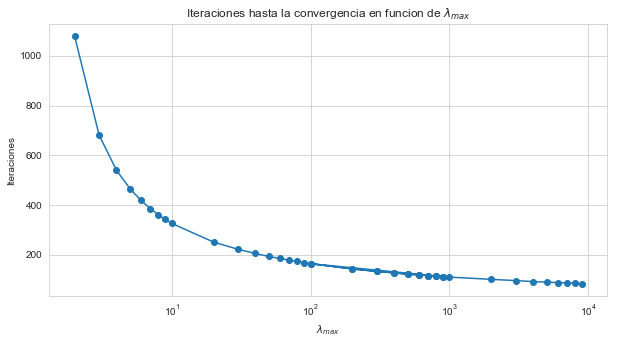

In [73]:
sns.set_style("whitegrid")
plt.figure(figsize=(10,5))
plt.plot(lambda_range, iters, marker='o')
plt.xscale('log')
plt.xlabel(r'$\lambda_{max}$')
plt.ylabel('Iteraciones')
plt.title(r'Iteraciones hasta la convergencia en funcion de $\lambda_{max}$')
plt.show()

# Analisis de la Velocidad de Convergencia

In [108]:
def error(M, out_dict, ord=np.inf):
    Mv = M.dot(out_dict['eigen_vec'])
    lv = out_dict['eigen_val'] * out_dict['eigen_vec']
    return np.linalg.norm(np.abs(Mv - lv), ord=ord)

def iters_to_converge_with_metrics(M, num_time_samples=10):
    # Write matrix to file.
    write_numpy_matrix_to_file(M, OUT_FILE)
    error_prev, error_next = None, None
    iters, errors, time = [], [], []
    curr_iter = 1
    while(None in (error_prev, error_next) or error_prev != error_next):
        times = []
        error_prev = error_next
        
        for i in range(20):
            out = run(EXEC_PATH, OUT_FILE, curr_iter)
            times.append(out['time'])
            error_next = error(M, out)
        
        time_avg = sum(times) / num_time_samples
        time.append(time_avg)
        iters.append(curr_iter)
        errors.append(error_next)
        curr_iter += 1
    
    print(len(errors))
    print(len(time))
    print(len(iters))
    return pd.DataFrame(data={'error': errors, 'time': time, 'iters': iters})

In [129]:
size = (30, 30)
lambda_max = 2
M = generate_diagonal_matrix_with_eigenvector(lambda_max=lambda_max, size=size)
df = iters_to_converge_with_metrics(M)

109
109
109


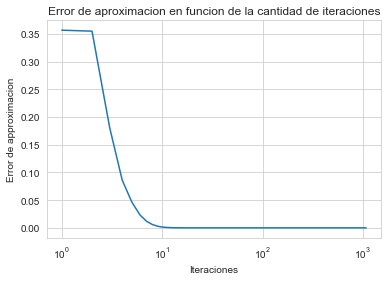

In [117]:
sns.lineplot(x="iters", y="error", data=df)
# plt.figure(figsize=(10,5))
#plt.yscale('log')
plt.xscale('log')
plt.xlabel('Iteraciones')
plt.ylabel('Error de approximacion')
plt.title('Error de aproximacion en funcion de la cantidad de iteraciones')
plt.show()

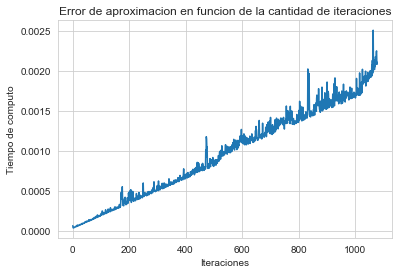

In [121]:
sns.lineplot(x="iters", y="time", data=df)
#plt.yscale('log')

#plt.xscale('log')
plt.xlabel('Iteraciones')
plt.ylabel('Tiempo de computo')
plt.title('Error de aproximacion en funcion de la cantidad de iteraciones')
plt.show()

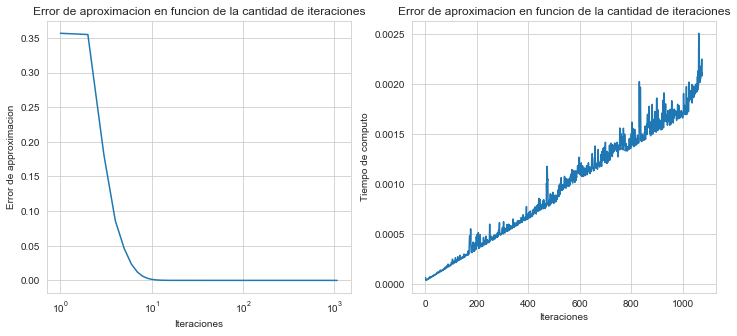

In [128]:
fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(121)

sns.lineplot(x="iters", y="error", data=df, ax=ax1)
# plt.figure(figsize=(10,5))
#plt.yscale('log')
ax1.set_xscale('log')
ax1.set_xlabel('Iteraciones')
ax1.set_ylabel('Error de approximacion')
ax1.set_title('Error de aproximacion en funcion de la cantidad de iteraciones')

ax2 = fig.add_subplot(122)
sns.lineplot(x="iters", y="time", data=df, ax=ax2)
#plt.yscale('log')

#plt.xscale('log')
ax2.set_xlabel('Iteraciones')
ax2.set_ylabel('Tiempo de computo')
ax2.set_title('Error de aproximacion en funcion de la cantidad de iteraciones')
plt.show()

